## Traffic forecasting using graph neural networks and LSTM
- https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

2022-11-25 08:27:26.567465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 08:27:26.996675: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 08:27:27.079694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 08:27:27.079718: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
route_distances = pd.read_csv(
    os.path.join("./data/queinfo_20220929.csv"))

In [3]:
speeds_array  = pd.read_csv(
    os.path.join("./data/queinfo_20220930.csv"))

In [4]:
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(155520, 5)
speeds_array shape=(155520, 5)


In [5]:
route_distances

,rsid,name,cnt_item,is_pending,insert_date_time
0,unirs01,recv_smt_slow.que,0,0,2022-09-29 00:00:01
1,unirs01,recv_mmt_slow.que,0,0,2022-09-29 00:00:01
2,unirs01,recv_smt_fast.que,0,0,2022-09-29 00:00:01
3,unirs01,recv_mmt_fast.que,0,0,2022-09-29 00:00:01
4,unirs01,dbmtfail.que,0,0,2022-09-29 00:00:01
...,...,...,...,...,...
155515,wngrs01,dbmt6.que,2,0,2022-09-29 23:59:03
155516,wngrs01,dbmtfail.que,0,0,2022-09-29 23:59:03
155517,wngrs02,dbmtfail.que,0,0,2022-09-29 23:59:03
155518,rcsrs01,recv_mmt_fast.que,0,0,2022-09-29 23:59:03


In [6]:
route_distances = route_distances.drop(["rsid", "name"], axis = 1)
speeds_array = speeds_array.drop(["rsid", "name"], axis = 1)

In [7]:
route_distances

,cnt_item,is_pending,insert_date_time
0,0,0,2022-09-29 00:00:01
1,0,0,2022-09-29 00:00:01
2,0,0,2022-09-29 00:00:01
3,0,0,2022-09-29 00:00:01
4,0,0,2022-09-29 00:00:01
...,...,...,...
155515,2,0,2022-09-29 23:59:03
155516,0,0,2022-09-29 23:59:03
155517,0,0,2022-09-29 23:59:03
155518,0,0,2022-09-29 23:59:03


In [15]:
speeds_array

,cnt_item,is_pending
insert_date_time,,
2022-09-30 00:00:01,0,0
2022-09-30 00:00:01,0,0
2022-09-30 00:00:01,0,0
2022-09-30 00:00:01,0,0
2022-09-30 00:00:01,0,0
...,...,...
2022-09-30 23:59:04,0,0
2022-09-30 23:59:04,0,0
2022-09-30 23:59:04,0,0


In [10]:
test = speeds_array.set_index('insert_date_time', inplace=True)

In [13]:
test

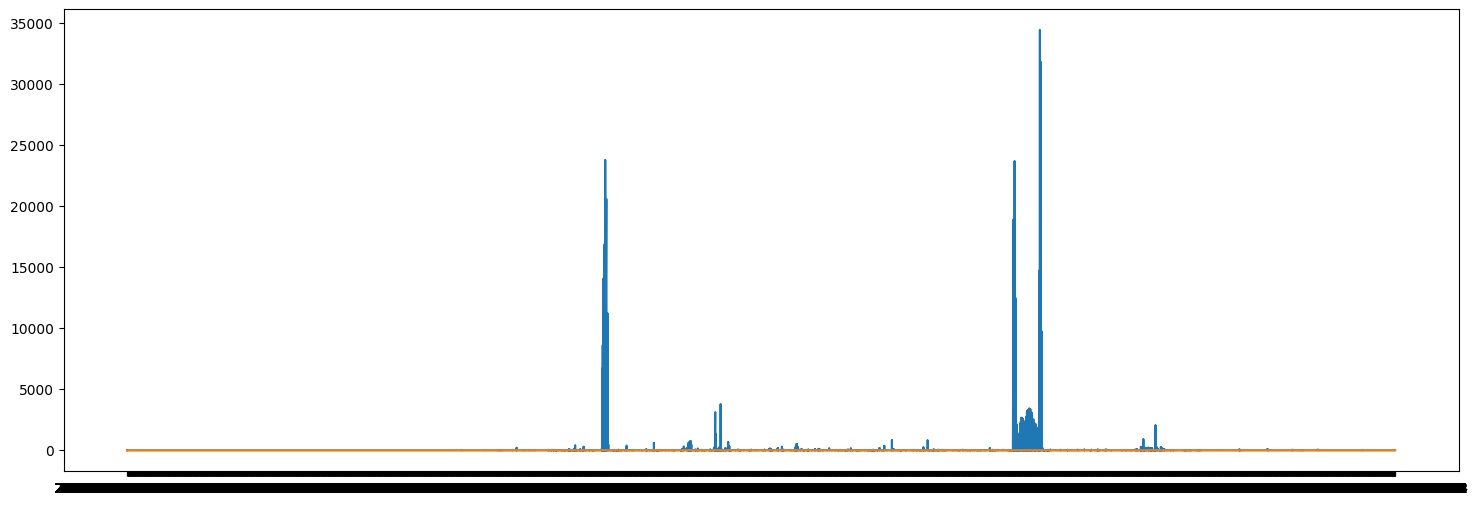

In [16]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array)
# plt.legend(["route_0", "route_25"])

Text(0, 0.5, 'road number')

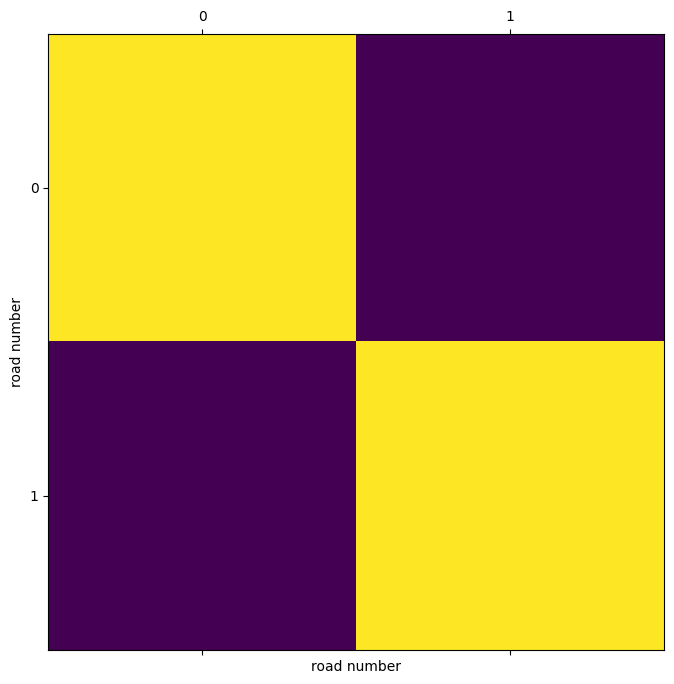

In [17]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")

In [18]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (77760, 2)
validation set size: (31104, 2)
test set size: (46656, 2)


In [19]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = tf.keras.preprocessing.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = tf.keras.preprocessing.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

2022-11-25 08:58:18.370189: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-25 08:58:18.370878: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-25 08:58:18.370988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (GELEE-IBD1): /proc/driver/nvidia/version does not exist
2022-11-25 08:58:18.374375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [21]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)

print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

TypeError: unsupported operand type(s) for /: 'str' and 'float'